In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

time: 445 µs (started: 2023-05-12 16:36:53 +00:00)


Load and preprocess the data

In [ ]:
#unzip the data that we had split earlier before in the preprocessing data notebook, to ensure that the same split data was used for every model
!unzip /isic2019-dataset.zip

In [5]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the data augmentation transformation pipeline for the training set.
#the specific data augmentation technique that will be applied is called RandAugment. 
randaug_transform = Compose([
    Resize(resize_size, interpolation=interpolation),
    transforms.CenterCrop(size=224),
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

#define the transformation function that will be used to pre-process the data in the imagefolder function from Pytorch for the validation and test set 
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC), #resize the image to 224 by 224
    transforms.CenterCrop(size=224), # apply centercrop
    transforms.ToTensor(), #converts the image from a PIL Image object to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalizes the tensor image
])

time: 4.45 ms (started: 2023-05-07 17:42:53 +00:00)


In [6]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 
#the code that was re-used is available at: https://github.com/optuna/optuna

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'mvitv2_large'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)

    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 17:42:53,635] A new study created in memory with name: no-name-c710ab8b-d7ff-4ef3-a566-31c78c9fefa4


Epoch 1: Train Loss = 1.1809, Train Accuracy = 61.65%, Validation Loss = 0.9381, Validation Accuracy = 67.48%, F1-score = 0.3785
Epoch 2: Train Loss = 0.9258, Train Accuracy = 66.92%, Validation Loss = 0.8572, Validation Accuracy = 69.29%, F1-score = 0.3952
Epoch 3: Train Loss = 0.8794, Train Accuracy = 68.26%, Validation Loss = 0.8201, Validation Accuracy = 69.25%, F1-score = 0.4235
Epoch 4: Train Loss = 0.8588, Train Accuracy = 69.05%, Validation Loss = 0.8127, Validation Accuracy = 69.84%, F1-score = 0.4560
Epoch 5: Train Loss = 0.8389, Train Accuracy = 69.88%, Validation Loss = 0.8106, Validation Accuracy = 69.48%, F1-score = 0.4369
Epoch 6: Train Loss = 0.8320, Train Accuracy = 70.10%, Validation Loss = 0.8356, Validation Accuracy = 68.11%, F1-score = 0.4820
Epoch 7: Train Loss = 0.8244, Train Accuracy = 70.02%, Validation Loss = 0.7923, Validation Accuracy = 69.40%, F1-score = 0.4499
Epoch 8: Train Loss = 0.8160, Train Accuracy = 70.50%, Validation Loss = 0.7872, Validation Accur

[I 2023-05-07 18:10:38,703] Trial 0 finished with value: 0.5410210020506661 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0018161584318438795, 'learning_rate': 0.0025984208660084986, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 0 with value: 0.5410210020506661.


Epoch 19: Train Loss = 0.7783, Train Accuracy = 71.75%, Validation Loss = 0.7732, Validation Accuracy = 71.48%, F1-score = 0.5310
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1140, Train Accuracy = 62.61%, Validation Loss = 0.8629, Validation Accuracy = 68.42%, F1-score = 0.3869
Epoch 2: Train Loss = 0.9276, Train Accuracy = 67.16%, Validation Loss = 0.8302, Validation Accuracy = 69.09%, F1-score = 0.4384
Epoch 3: Train Loss = 0.8907, Train Accuracy = 67.78%, Validation Loss = 0.9213, Validation Accuracy = 65.83%, F1-score = 0.4612
Epoch 4: Train Loss = 0.8695, Train Accuracy = 68.86%, Validation Loss = 0.8033, Validation Accuracy = 70.11%, F1-score = 0.4646
Epoch 5: Train Loss = 0.8507, Train Accuracy = 69.24%, Validation Loss = 0.7970, Validation Accuracy = 70.11%, F1-score = 0.4644
Epoch 6: Train Loss = 0.8496, Train Accuracy = 69.35%, Validation Loss = 0.7964, Validation Accuracy = 70.90%, F1-score = 0.5080
Epoch 7: Train Loss = 0.8330, Train Accuracy

[I 2023-05-07 18:40:31,126] Trial 1 finished with value: 0.5535720392533141 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0017865031104105768, 'learning_rate': 0.0011389670950301305, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 1 with value: 0.5535720392533141.


Epoch 20: Train Loss = 0.7663, Train Accuracy = 71.70%, Validation Loss = 0.7533, Validation Accuracy = 72.43%, F1-score = 0.5315
Epoch 1: Train Loss = 1.3555, Train Accuracy = 57.12%, Validation Loss = 1.0158, Validation Accuracy = 66.50%, F1-score = 0.3417
Epoch 2: Train Loss = 0.9336, Train Accuracy = 66.78%, Validation Loss = 0.8570, Validation Accuracy = 68.11%, F1-score = 0.3774
Epoch 3: Train Loss = 0.8870, Train Accuracy = 68.43%, Validation Loss = 0.8508, Validation Accuracy = 68.58%, F1-score = 0.3952
Epoch 4: Train Loss = 0.8655, Train Accuracy = 68.68%, Validation Loss = 0.8186, Validation Accuracy = 69.72%, F1-score = 0.4358
Epoch 5: Train Loss = 0.8492, Train Accuracy = 69.17%, Validation Loss = 0.8042, Validation Accuracy = 70.15%, F1-score = 0.4182
Epoch 6: Train Loss = 0.8383, Train Accuracy = 69.77%, Validation Loss = 0.8081, Validation Accuracy = 69.60%, F1-score = 0.4368
Epoch 7: Train Loss = 0.8286, Train Accuracy = 70.01%, Validation Loss = 0.8158, Validation Accu

[I 2023-05-07 18:52:30,951] Trial 2 finished with value: 0.45536602904575996 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0021811606710562476, 'learning_rate': 0.0011937104646619879, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 1 with value: 0.5535720392533141.


Epoch 8: Train Loss = 0.8176, Train Accuracy = 70.36%, Validation Loss = 0.8059, Validation Accuracy = 69.95%, F1-score = 0.4554
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2489, Train Accuracy = 59.80%, Validation Loss = 0.9684, Validation Accuracy = 66.85%, F1-score = 0.3026
Epoch 2: Train Loss = 0.9298, Train Accuracy = 67.23%, Validation Loss = 0.8598, Validation Accuracy = 68.85%, F1-score = 0.3921
Epoch 3: Train Loss = 0.8861, Train Accuracy = 68.14%, Validation Loss = 0.8254, Validation Accuracy = 68.97%, F1-score = 0.4019
Epoch 4: Train Loss = 0.8713, Train Accuracy = 69.21%, Validation Loss = 0.8783, Validation Accuracy = 66.77%, F1-score = 0.3781
Epoch 5: Train Loss = 0.8494, Train Accuracy = 69.30%, Validation Loss = 0.8210, Validation Accuracy = 69.56%, F1-score = 0.4389
Epoch 6: Train Loss = 0.8366, Train Accuracy = 69.89%, Validation Loss = 0.7975, Validation Accuracy = 70.90%, F1-score = 0.4359
Epoch 7: Train Loss = 0.8332, Train Accuracy 

[I 2023-05-07 19:06:00,237] Trial 3 finished with value: 0.4586832073382877 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0022824583955187248, 'learning_rate': 0.0023457524220021173, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 0.5535720392533141.


Epoch 9: Train Loss = 0.8105, Train Accuracy = 70.88%, Validation Loss = 0.7991, Validation Accuracy = 70.38%, F1-score = 0.4587
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2538, Train Accuracy = 60.63%, Validation Loss = 0.9568, Validation Accuracy = 68.38%, F1-score = 0.3700
Epoch 2: Train Loss = 0.9230, Train Accuracy = 67.21%, Validation Loss = 0.8675, Validation Accuracy = 68.77%, F1-score = 0.3815
Epoch 3: Train Loss = 0.8824, Train Accuracy = 68.49%, Validation Loss = 0.8304, Validation Accuracy = 69.48%, F1-score = 0.4184
Epoch 4: Train Loss = 0.8619, Train Accuracy = 68.96%, Validation Loss = 0.8170, Validation Accuracy = 69.95%, F1-score = 0.4213
Epoch 5: Train Loss = 0.8430, Train Accuracy = 69.55%, Validation Loss = 0.8061, Validation Accuracy = 70.23%, F1-score = 0.4664
Epoch 6: Train Loss = 0.8411, Train Accuracy = 69.72%, Validation Loss = 0.7822, Validation Accuracy = 71.01%, F1-score = 0.4582
Epoch 7: Train Loss = 0.8324, Train Accuracy 

[I 2023-05-07 19:19:30,202] Trial 4 finished with value: 0.47775233920648413 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0033955296931704126, 'learning_rate': 0.0012313919046828144, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 0.5535720392533141.


Epoch 9: Train Loss = 0.8122, Train Accuracy = 70.47%, Validation Loss = 0.7984, Validation Accuracy = 70.23%, F1-score = 0.4755
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2193, Train Accuracy = 59.09%, Validation Loss = 0.9328, Validation Accuracy = 66.89%, F1-score = 0.3087
Epoch 2: Train Loss = 0.9436, Train Accuracy = 66.19%, Validation Loss = 0.8943, Validation Accuracy = 66.85%, F1-score = 0.3650
Epoch 3: Train Loss = 0.9059, Train Accuracy = 67.78%, Validation Loss = 0.8843, Validation Accuracy = 68.11%, F1-score = 0.3762
Epoch 4: Train Loss = 0.9033, Train Accuracy = 67.48%, Validation Loss = 0.8685, Validation Accuracy = 68.15%, F1-score = 0.3554
Epoch 5: Train Loss = 0.9027, Train Accuracy = 67.76%, Validation Loss = 0.8889, Validation Accuracy = 68.30%, F1-score = 0.3358
Epoch 6: Train Loss = 0.9051, Train Accuracy = 67.65%, Validation Loss = 0.8575, Validation Accuracy = 69.05%, F1-score = 0.3507
Epoch 7: Train Loss = 0.9020, Train Accuracy 

[I 2023-05-07 19:49:23,766] Trial 5 finished with value: 0.4266718383460204 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.006882011822375617, 'learning_rate': 0.006061002112284173, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 0.5535720392533141.


Epoch 20: Train Loss = 0.8770, Train Accuracy = 68.40%, Validation Loss = 0.8283, Validation Accuracy = 69.36%, F1-score = 0.3761
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2390, Train Accuracy = 60.25%, Validation Loss = 0.9679, Validation Accuracy = 65.99%, F1-score = 0.3585
Epoch 2: Train Loss = 0.9289, Train Accuracy = 66.92%, Validation Loss = 0.8430, Validation Accuracy = 69.13%, F1-score = 0.3936
Epoch 3: Train Loss = 0.8856, Train Accuracy = 67.73%, Validation Loss = 0.8356, Validation Accuracy = 69.44%, F1-score = 0.4202
Epoch 4: Train Loss = 0.8690, Train Accuracy = 68.42%, Validation Loss = 0.8496, Validation Accuracy = 68.74%, F1-score = 0.4233
Epoch 5: Train Loss = 0.8639, Train Accuracy = 68.60%, Validation Loss = 0.8425, Validation Accuracy = 68.46%, F1-score = 0.3745
Epoch 6: Train Loss = 0.8528, Train Accuracy = 69.36%, Validation Loss = 0.8119, Validation Accuracy = 69.95%, F1-score = 0.4013
Epoch 7: Train Loss = 0.8508, Train Accuracy

[I 2023-05-07 20:07:16,684] Trial 6 finished with value: 0.4232664626364101 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.007663452885423734, 'learning_rate': 0.00310236744726275, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 0.5535720392533141.


Epoch 12: Train Loss = 0.8512, Train Accuracy = 69.52%, Validation Loss = 0.8248, Validation Accuracy = 69.17%, F1-score = 0.3971
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1329, Train Accuracy = 61.66%, Validation Loss = 0.9421, Validation Accuracy = 65.79%, F1-score = 0.3338
Epoch 2: Train Loss = 0.9374, Train Accuracy = 66.30%, Validation Loss = 0.8729, Validation Accuracy = 68.11%, F1-score = 0.3724
Epoch 3: Train Loss = 0.9210, Train Accuracy = 67.03%, Validation Loss = 0.8866, Validation Accuracy = 67.40%, F1-score = 0.3190
Epoch 4: Train Loss = 0.9226, Train Accuracy = 67.10%, Validation Loss = 0.8763, Validation Accuracy = 67.95%, F1-score = 0.3463


[I 2023-05-07 20:14:48,278] Trial 7 finished with value: 0.3723972102008124 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.007936755294759729, 'learning_rate': 0.0083021419382449, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 0.5535720392533141.


Epoch 5: Train Loss = 0.9188, Train Accuracy = 67.32%, Validation Loss = 0.8791, Validation Accuracy = 67.99%, F1-score = 0.3390
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1108, Train Accuracy = 62.06%, Validation Loss = 0.9268, Validation Accuracy = 66.81%, F1-score = 0.3653
Epoch 2: Train Loss = 0.9483, Train Accuracy = 66.22%, Validation Loss = 0.8575, Validation Accuracy = 68.58%, F1-score = 0.4138
Epoch 3: Train Loss = 0.9071, Train Accuracy = 67.26%, Validation Loss = 0.8447, Validation Accuracy = 69.95%, F1-score = 0.4189
Epoch 4: Train Loss = 0.8839, Train Accuracy = 68.44%, Validation Loss = 0.8713, Validation Accuracy = 67.99%, F1-score = 0.4136
Epoch 5: Train Loss = 0.8711, Train Accuracy = 68.68%, Validation Loss = 0.8372, Validation Accuracy = 68.97%, F1-score = 0.4450
Epoch 6: Train Loss = 0.8533, Train Accuracy = 69.35%, Validation Loss = 0.8601, Validation Accuracy = 69.40%, F1-score = 0.4486
Epoch 7: Train Loss = 0.8399, Train Accuracy 

[I 2023-05-07 20:41:48,743] Trial 8 finished with value: 0.5560009899901481 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.00964031471261964, 'learning_rate': 0.0023991577090956874, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 8 with value: 0.5560009899901481.


Epoch 18: Train Loss = 0.7852, Train Accuracy = 71.64%, Validation Loss = 0.7776, Validation Accuracy = 71.76%, F1-score = 0.4819
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2220, Train Accuracy = 59.44%, Validation Loss = 0.9445, Validation Accuracy = 65.51%, F1-score = 0.3577
Epoch 2: Train Loss = 0.9542, Train Accuracy = 65.75%, Validation Loss = 0.8633, Validation Accuracy = 68.97%, F1-score = 0.4379
Epoch 3: Train Loss = 0.8998, Train Accuracy = 67.56%, Validation Loss = 0.8640, Validation Accuracy = 68.19%, F1-score = 0.3936
Epoch 4: Train Loss = 0.8851, Train Accuracy = 67.96%, Validation Loss = 0.8337, Validation Accuracy = 69.68%, F1-score = 0.4144
Epoch 5: Train Loss = 0.8723, Train Accuracy = 68.69%, Validation Loss = 0.7962, Validation Accuracy = 70.58%, F1-score = 0.4933
Epoch 6: Train Loss = 0.8591, Train Accuracy = 69.18%, Validation Loss = 0.8242, Validation Accuracy = 69.48%, F1-score = 0.4634
Epoch 7: Train Loss = 0.8481, Train Accuracy

[I 2023-05-07 21:01:13,906] Trial 9 finished with value: 0.5285109808167603 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0024484696468886364, 'learning_rate': 0.005145890625912551, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 8 with value: 0.5560009899901481.


Epoch 13: Train Loss = 0.8129, Train Accuracy = 70.46%, Validation Loss = 0.8418, Validation Accuracy = 69.17%, F1-score = 0.4827
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5560009899901481
  Params: 
    optimizer_name: AdamW
    weight_decay: 0.00964031471261964
    learning_rate: 0.0023991577090956874
    dropout: 0.25
    num_hidden_layers: 2
    num_neurons: 256
time: 3h 18min 20s (started: 2023-05-07 17:42:53 +00:00)


/tmp/ipykernel_5962/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

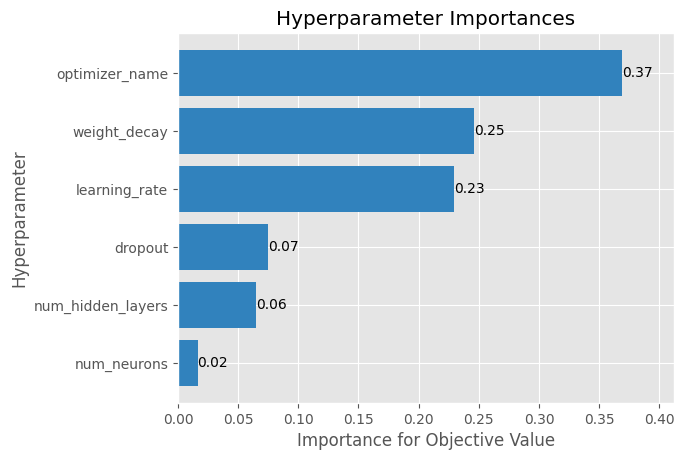

time: 387 ms (started: 2023-05-07 21:01:31 +00:00)


In [9]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [10]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'AdamW', 'weight_decay': 0.00964031471261964, 'learning_rate': 0.0023991577090956874, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}
time: 1.08 ms (started: 2023-05-07 21:01:31 +00:00)


Concatenate the training and validation dataset into one final training set 

In [ ]:
import os
import shutil

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)

Use the imagefolder and dataloader function from Pytorch to preprocess and load the data to re-train the model on the final training set and evaluate on the test set, using the best obtained hyperparameter values during Hyperparameter tuning 

In [4]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data, apply data augmentation (Randaugment) only for the training set 
train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

time: 48.1 ms (started: 2023-05-12 16:37:06 +00:00)


In [5]:
import timm 
#look up all the maxvit models in timm's library
mvit_models = timm.list_models('*mvit*')
mvit_models

['mvitv2_base',
 'mvitv2_base_cls',
 'mvitv2_huge_cls',
 'mvitv2_large',
 'mvitv2_large_cls',
 'mvitv2_small',
 'mvitv2_small_cls',
 'mvitv2_tiny']

time: 152 ms (started: 2023-05-12 16:37:06 +00:00)


Create the mvitv2_large model from Timm's library

In [ ]:
#create the mvitv2 model
#The deep learning library called Timm was used to create the pre-trained models which has the weights pre-loaded. 
#A link to the github library is available at: https://github.com/huggingface/pytorch-image-models
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('mvitv2_large', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head with the best hyperparameter values
num_hidden_layers = 2
num_neurons = 256
dropout = 0.25
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [7]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiScaleVit (MultiScaleVit)                                [32, 3, 224, 224]    [32, 8]              --                   Partial
├─PatchEmbed (patch_embed)                                   [32, 3, 224, 224]    [32, 3136, 144]      --                   False
│    └─Conv2d (proj)                                         [32, 3, 224, 224]    [32, 144, 56, 56]    (21,312)             False
├─ModuleList (stages)                                        --                   --                   --                   False
│    └─MultiScaleVitStage (0)                                [32, 3136, 144]      [32, 3136, 288]      --                   False
│    │    └─ModuleList (blocks)                              --                   --                   (662,976)            False
│    └─MultiScaleVitStage (1)                                [32, 3136, 288]      [3

time: 1.94 s (started: 2023-05-12 16:38:34 +00:00)


In [8]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.0023991577090956874, weight_decay = 0.00964031471261964)

time: 2.9 ms (started: 2023-05-12 16:38:36 +00:00)


In [9]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 18
num_epochs = 18

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/18: Train Loss: 1.0954, Train Acc: 62.3806, Test Loss: 0.9429, Test Acc: 66.0015
Epoch 2/18: Train Loss: 0.9366, Train Acc: 66.4422, Test Loss: 0.9164, Test Acc: 67.2678
Epoch 3/18: Train Loss: 0.8949, Train Acc: 67.8460, Test Loss: 0.8955, Test Acc: 68.8411
Epoch 4/18: Train Loss: 0.8809, Train Acc: 68.4708, Test Loss: 0.9229, Test Acc: 66.3469
Epoch 5/18: Train Loss: 0.8650, Train Acc: 68.9153, Test Loss: 0.8717, Test Acc: 68.0353
Epoch 6/18: Train Loss: 0.8482, Train Acc: 69.5534, Test Loss: 0.9147, Test Acc: 68.5342
Epoch 7/18: Train Loss: 0.8318, Train Acc: 69.9406, Test Loss: 0.8360, Test Acc: 70.0691
Epoch 8/18: Train Loss: 0.8309, Train Acc: 70.1034, Test Loss: 0.8292, Test Acc: 69.5318
Epoch 9/18: Train Loss: 0.8282, Train Acc: 70.2398, Test Loss: 0.8261, Test Acc: 69.0330
Epoch 10/18: Train Loss: 0.8171, Train Acc: 70.2530, Test Loss: 0.8321, Test Acc: 69.1097
Epoch 11/18: Train Loss: 0.8038, Train Acc: 71.0891, Test Loss: 0.8322, Test Acc: 69.7237
Epoch 12/18: Train 

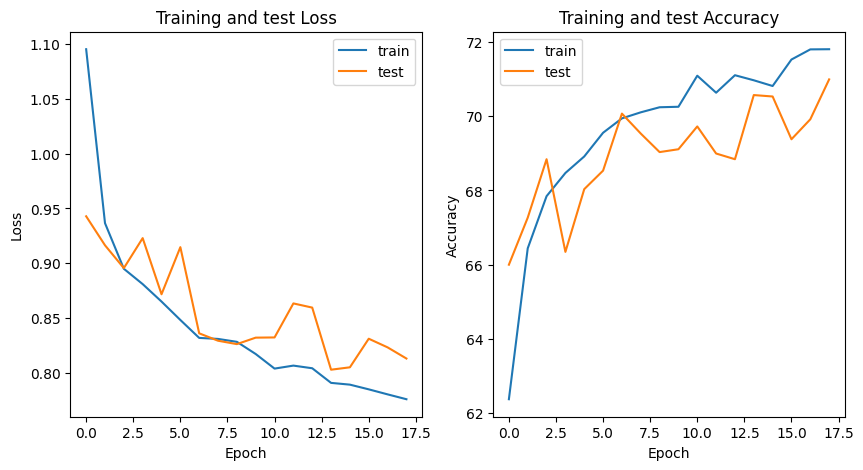

time: 246 ms (started: 2023-05-12 17:27:31 +00:00)


In [10]:
# Plot the training and testing loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [11]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
tprs = []
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    tpr = tp / (tp + fn)
    tprs.append(tpr)
sensitivity = np.mean(tprs)
test_accuracy /= 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8130
Test Accuracy: 0.7099
Sensitivity: 0.4914
ROC-AUC: 0.9042
F1-score: 0.5252
Classification Report:
              precision    recall  f1-score   support

           0     0.4872    0.2135    0.2969        89
           1     0.5445    0.8071    0.6503       311
           2     0.5336    0.4601    0.4942       276
           3     0.7000    0.2593    0.3784        27
           4     0.6884    0.4222    0.5234       450
           5     0.8125    0.8962    0.8523      1349
           6     0.4578    0.4634    0.4606        82
           7     0.8182    0.4091    0.5455        22

    accuracy                         0.7099      2606
   macro avg     0.6303    0.4914    0.5252      2606
weighted avg     0.7062    0.7099    0.6947      2606

time: 541 ms (started: 2023-05-12 17:27:32 +00:00)


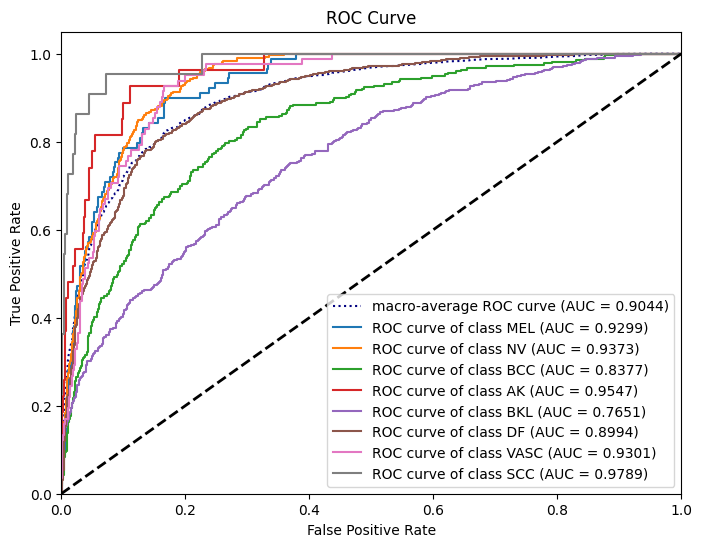

time: 166 ms (started: 2023-05-12 17:27:32 +00:00)


In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

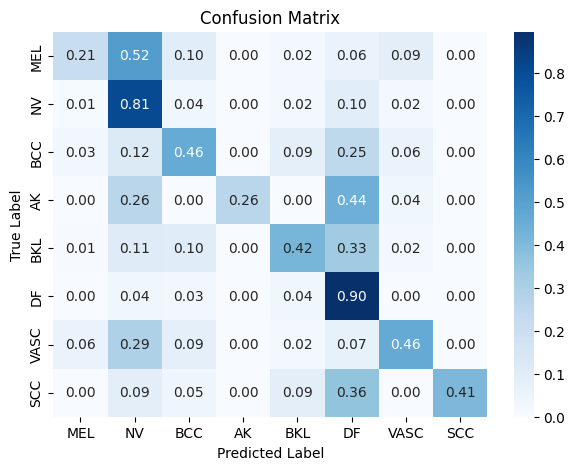

time: 332 ms (started: 2023-05-12 17:27:32 +00:00)


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

Reference to the specific libraries that were used in this code

• Ross Wightman. "PyTorch Image Models." GitHub repository. 2019. [Online]. Available: https://github.com/rwightman/pytorch-image-models.

• Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019. Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD (arXiv).